In [2]:
%reset
%load_ext autoreload
%autoreload 2

import sys

sys.path.append("../")

import numpy as np
import matplotlib.pyplot as plt
import torch

import defmod as dm
import multimodule_usefulfunctions as mm 
import hamiltonian_multishape as ham
import kernels as ker

Once deleted, variables cannot be recovered. Proceed (y/[n])? y
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
## define reference and template shape
r = [3,2]
origin1 = [[-3,0], [6,6]]
origin2 = [[0,3], [6,4]]
nb_points = [10,7]

source = mm.multipleCircles(origin1, r ,nb_points)
target = mm.multipleCircles(origin2, r ,nb_points)

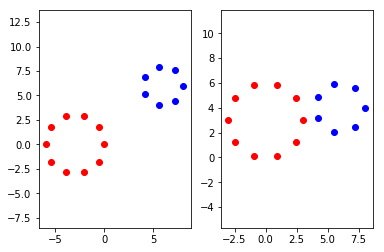

In [5]:
plt.subplot(1,2,1)
plt.scatter(source[0][:, 0].detach().numpy(), source[0][:, 1].detach().numpy(), c='red')
plt.scatter(source[1][:, 0].detach().numpy(), source[1][:, 1].detach().numpy(), c='blue')

plt.axis('equal')
plt.subplot(1,2,2)
plt.scatter(target[0][:, 0].detach().numpy(), target[0][:, 1].detach().numpy(), c='red')
plt.scatter(target[1][:, 0].detach().numpy(), target[1][:, 1].detach().numpy(), c='blue')

plt.axis('equal')
plt.show()

In [6]:
## Define Deformation Modules
dim = 2
nb_shapes = 2

# Module 1: Translation of first circle
sigma1 = 10
trans1 = dm.deformationmodules.Translations(dim, 1, sigma1)
trans1 = dm.deformationmodules.GlobalTranslation(dim, sigma1)

# Module 2: Translation of second circle
sigma2 = 10
trans2 = dm.deformationmodules.Translations(dim,1, sigma2)
trans2 = dm.deformationmodules.GlobalTranslation(dim, sigma2)

# Module 3: Background Module
sigma3 = 1.5
nb_pts = nb_points[0] + nb_points[1]
background = dm.deformationmodules.Translations(dim, nb_pts, sigma3)


module_list = [trans1, trans2, background]
dim_controls = dim*(1+1+nb_pts)

In [7]:
sigma = [sigma1, sigma2, sigma3]
z = [mm.computeCenter(source[0]), mm.computeCenter(source[1])]

#initialize gd and momentum
mom_tmp0 = np.zeros([nb_points[0], dim])
mom_tmp0[:,1] = 10.
mom_tmp1 = np.zeros([nb_points[1], dim])
mom_tmp1[:,1] = -10.
gd_list = [source[0], source[1], torch.cat([source[0], source[1]],0)]
mom_list = [torch.tensor(mom_tmp0.copy(), requires_grad=True, dtype=torch.float32), torch.tensor(mom_tmp1.copy(),requires_grad=True, dtype=torch.float32), torch.tensor(np.zeros(gd_list[2].shape),requires_grad=True, dtype=torch.float32)]

# compute geodesic control and lagrange multiplier
l_list = mm.lambda_qp(gd_list, mom_list, sigma, z, dim)
controls_list = mm.h_qp(gd_list, mom_list, l_list, sigma, z, dim)

# Constraints (identity)
Constr1 = torch.cat([torch.eye(nb_points[0]), torch.zeros([nb_points[0], nb_points[1]]), -torch.eye(nb_points[0]), torch.zeros([nb_points[0], nb_points[1]])], 1)
Constr2 = torch.cat([torch.zeros([nb_points[1], nb_points[0]]), torch.eye(nb_points[1]), torch.zeros([nb_points[1], nb_points[0]]), -torch.eye(nb_points[1]),], 1)
Constr = [Constr1, Constr2]

# reduced Hamiltonian 
dim_control = [controls_list[0].shape, controls_list[1].shape, controls_list[2].shape]
H = ham.Hamiltonian_Multishape(module_list, dim_control)

In [8]:
gd_t, mom_t, controls_t = mm.shootMultishape(gd_list, mom_list, H, Constr, sigma, dim, n=10)

gd_final = gd_t[len(gd_t)-1]
mom_final = mom_t[len(mom_t)-1]


z_final = [mm.computeCenter(source[0]), mm.computeCenter(source[1])]
l_final = mm.lambda_qp(gd_final, mom_final, sigma, z_final, dim)
control_final = mm.h_qp(gd_final, mom_final, l_final, sigma, z, dim)

nb_modules = 2
N = len(controls_t)
center_t = torch.zeros( N, nb_modules, dim)
for t in range(N):
    for m in range(2):
        center_t[t, m] = mm.computeCenter(gd_t[t][m])

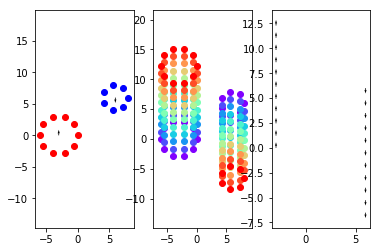

In [9]:
import matplotlib.cm as cm

# Geometrical descriptors at initial time
plt.subplot(1,3,1)
plt.scatter(source[0][:, 0].detach().numpy(), source[0][:, 1].detach().numpy(), c='red')
plt.scatter(source[1][:, 0].detach().numpy(), source[1][:, 1].detach().numpy(), c='blue')
mm.plotControl(controls_list, z)
plt.axis('equal')

# Geometrical Descriptors transported over time by shooting
plt.subplot(1,3,2)
colors = cm.rainbow(np.linspace(0, 1, len(gd_t)))
for i,c in zip(range(len(gd_t)), colors):
    plt.scatter(gd_t[i][0][:,0].detach().numpy(), gd_t[i][0][:, 1].detach().numpy(), color=c)
    plt.scatter(gd_t[i][1][:,0].detach().numpy(), gd_t[i][1][:, 1].detach().numpy(), color=c)
plt.axis('equal')

# controls over time
plt.subplot(1,3,3)
for i in range(len(controls_t)):
    mm.plotControl(controls_t[i], [center_t[i][0],center_t[i][1]])
plt.axis('equal')

plt.show()

In [10]:
controls1_t = []
controls2_t = []
controls3_t = []
gd3_t = []

for t in range(len(controls_t)):
    controls1_t.append(controls_t[t][0])
    controls2_t.append(controls_t[t][1])
    controls3_t.append(controls_t[t][2])
    gd3_t.append(gd_t[t][2])

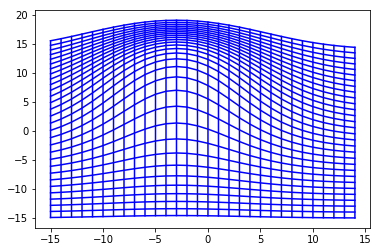

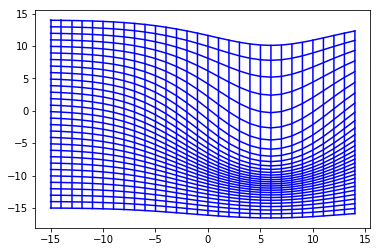

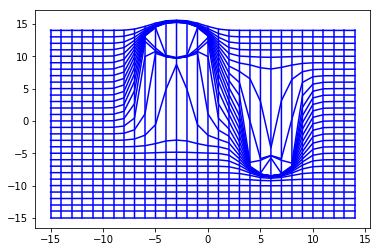

In [11]:
# Visualization of grid deformation for each submodule
nx, ny = 30, 30
sx, sy = 30, 30
x, y = torch.meshgrid([torch.arange(0, nx), torch.arange(0, ny)])
x = sx*(x.type(torch.FloatTensor)/nx - 0.5)
y = sy*(y.type(torch.FloatTensor)/ny - 0.5)

gridpoints = dm.usefulfunctions.grid2vec(x, y).type(torch.FloatTensor)


phi1 = mm.largeDeformation(trans1, center_t[:,0,:], controls1_t, gridpoints)
x1, y1 = dm.usefulfunctions.vec2grid(phi1, nx, ny)

phi2 = mm.largeDeformation(trans2, center_t[:,1,:], controls2_t, gridpoints)
x2, y2 = dm.usefulfunctions.vec2grid(phi2, nx, ny)

phi3 = mm.largeDeformation(background, gd3_t, controls3_t, gridpoints)
x3, y3 = dm.usefulfunctions.vec2grid(phi3, nx, ny)


mm.plot_grid( x1.detach().numpy(), y1.detach().numpy(), color = 'blue')
mm.plot_grid(x2.detach().numpy(), y2.detach().numpy(), color = 'blue')
mm.plot_grid( x3.detach().numpy(), y3.detach().numpy(), color = 'blue')
plt.show()


In [15]:
# Final Deformation of the Multishape module
 # using the deformatation corresponding to the label of each gridpoint
%matplotlib qt
grid = [x,y]
phi = [[x1,y1], [x2,y2], [x3,y3]]
label = mm.pointInCircles(x,y,z,r)

mm.plot_MultiGrid(phi, grid, label)
plt.show()

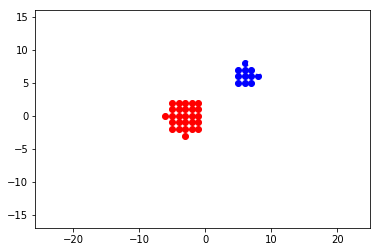

In [14]:
# Visualization of labeled gridpoints
color = ['red', 'blue', 'white']
for i in range(x.shape[0]):
    for j in range(x.shape[1]):
        plt.scatter(x[i][j].numpy(), y[i][j].numpy() , c=color[int(label[i][j].numpy())-1])
plt.axis('equal')
plt.show()

In [33]:
# check if gradient of Hamiltonian wrt h is zero
def tensor2list(x, nb_pts):
    x_list = [x[0:nb_pts[0]], x[nb_pts[0]:nb_pts[0]+nb_pts[1]], x[nb_pts[1]+nb_pts[0]:]]
    return x_list

def list2tensor(x):
    x_tensor = torch.tensor(x[0])
    for i in range(len(x)-1):
        x_tensor = torch.cat([x_tensor, x[1+i]],0)
    return x_tensor

def Hamiltonianh(controls):
    controls_list = tensor2list(controls, [1,1,nb_points])
    return H(gd_list, mom_list, controls_list, l_list, Constr)

controls = list2tensor(controls_list)

torch.autograd.grad(Hamiltonianh(controls), controls)

/home/rosa/.local/share/miniconda2/envs/py3projects/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


(tensor([[ 0.0000e+00, -4.7684e-06],
         [ 0.0000e+00, -1.9073e-06],
         [ 0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00]]),)